## Kamper D214 Performance Assessment Task 2 Code

## Research Question

Do the Project Cost and Expected KWh Annual Production variables have a significant impact on incentive amounts to be used to predict a high or low amount for a PV project under the NYSERDA program?

## Hypothesis

Null hypothesis - A statistically significant model cannot be built from the Project Cost and Expected KWh Annual Production variables to predict the incentive amount as high or low.  

Alternate Hypothesis - A statistically significant predictive model can be built from the Project Cost and Expected KWh Annual Production variables to predict the incentive amount as high or low.

## Install Necessary Libraries

In [1]:
# For General Use:
!pip install pandas
!pip install numpy

# For Modeling:
!pip install keras
!pip install tensorflow

## Import Necessary Packages

In [2]:
# For General Use:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
import seaborn as sns

# For Modeling:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

#For Evaluation:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Import Data

In [3]:
# Load CSV file to Pandas data frame.
nyserda_df = pd.read_csv('Solar_Electric_Programs_Reported_by_NYSERDA__Beginning_2000_20240402.csv', low_memory=False)

In [4]:
# Review data frame to ensure all is loaded as expected.
nyserda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162730 entries, 0 to 162729
Data columns (total 47 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Reporting Period                                    162730 non-null  object 
 1   Project Number                                      162730 non-null  object 
 2   Legacy Project Number                               55290 non-null   object 
 3   Street Address                                      10007 non-null   object 
 4   City                                                162730 non-null  object 
 5   County                                              162729 non-null  object 
 6   State                                               162730 non-null  object 
 7   ZIP Code                                            162730 non-null  int64  
 8   Incorporated Municipality                           162482 non-n

In [5]:
# Print data frame.
print(nyserda_df)

       Reporting Period Project Number Legacy Project Number  \
0             2/29/2024         691293                   NaN   
1             2/29/2024         713651                   NaN   
2             2/29/2024         580034                   NaN   
3             2/29/2024         715572                   NaN   
4             2/29/2024         457787                   NaN   
...                 ...            ...                   ...   
162725        2/29/2024          23591            4947-33151   
162726        2/29/2024          47551           4473-100953   
162727        2/29/2024         206746                   NaN   
162728        2/29/2024         193395                   NaN   
162729        2/29/2024         228654                   NaN   

                     Street Address         City  County State  ZIP Code  \
0                               NaN     BROOKLYN   Kings    NY     11236   
1                               NaN   Whitestone  Queens    NY     11357   
2  

## Clean and Prepare Data

In [6]:
# Remove variables (columns) not needed.  Review data set.
columns_to_keep = ['Project Number', 'Project Cost', 'Total NYSERDA Incentive', 'Expected KWh Annual Production']
nyserda_df = nyserda_df.drop(nyserda_df.columns.difference(columns_to_keep), axis=1)
nyserda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162730 entries, 0 to 162729
Data columns (total 4 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Project Number                  162730 non-null  object 
 1   Project Cost                    162730 non-null  float64
 2   Total NYSERDA Incentive         162660 non-null  float64
 3   Expected KWh Annual Production  162665 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.0+ MB


In [7]:
# Identify and drop duplicated columns based on "Project Number" variable.  Review data set.
nyserda_df = nyserda_df.drop_duplicates(subset="Project Number", keep='first')
nyserda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162730 entries, 0 to 162729
Data columns (total 4 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Project Number                  162730 non-null  object 
 1   Project Cost                    162730 non-null  float64
 2   Total NYSERDA Incentive         162660 non-null  float64
 3   Expected KWh Annual Production  162665 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.0+ MB


In [8]:
# Review for rows with null values.
nyserda_df.isnull().sum()

Project Number                     0
Project Cost                       0
Total NYSERDA Incentive           70
Expected KWh Annual Production    65
dtype: int64

In [9]:
# Remove rows with nulls.  Review data set.
nyserda_df = nyserda_df.dropna()
nyserda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162595 entries, 0 to 162729
Data columns (total 4 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Project Number                  162595 non-null  object 
 1   Project Cost                    162595 non-null  float64
 2   Total NYSERDA Incentive         162595 non-null  float64
 3   Expected KWh Annual Production  162595 non-null  float64
dtypes: float64(3), object(1)
memory usage: 6.2+ MB


In [10]:
# Calculate bin thresholds for incentive category designation.  Print bin values.
bins = pd.qcut(nyserda_df['Total NYSERDA Incentive'], q=2, labels=['0', '1'])
print(bins)

0         0
1         0
2         1
3         0
4         1
         ..
162725    1
162726    1
162727    1
162728    1
162729    1
Name: Total NYSERDA Incentive, Length: 162595, dtype: category
Categories (2, object): ['0' < '1']


In [11]:
# Create new column for category designations and apply them.  Review counts to ensure size is even.
nyserda_df['Incentive Category'] = bins

In [12]:
# Review data set and intitial values.
nyserda_df.info()
nyserda_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 162595 entries, 0 to 162729
Data columns (total 5 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Project Number                  162595 non-null  object  
 1   Project Cost                    162595 non-null  float64 
 2   Total NYSERDA Incentive         162595 non-null  float64 
 3   Expected KWh Annual Production  162595 non-null  float64 
 4   Incentive Category              162595 non-null  category
dtypes: category(1), float64(3), object(1)
memory usage: 6.4+ MB


,Project Number,Project Cost,Total NYSERDA Incentive,Expected KWh Annual Production,Incentive Category
0,691293,25476.01,880.0,5131.0,0
1,713651,14499.00,1440.0,7986.0,0
2,580034,41006.00,3038.0,12517.0,1
3,715572,18025.00,1012.0,5991.0,0
4,457787,0.00,3375.0,0.0,1


## Export Prepared Data Set

In [13]:
# Export the cleaned and prepared data frame as CSV file.
nyserda_df.to_csv("nyserda_df_prepared.csv")

## Exploratory Analysis

In [14]:
# Review summary statistics of the data frame.
print(nyserda_df[['Project Cost', 'Total NYSERDA Incentive', 'Expected KWh Annual Production']].describe())

       Project Cost  Total NYSERDA Incentive  Expected KWh Annual Production
count  1.625950e+05             1.625950e+05                    1.625950e+05
mean   9.495417e+04             1.689562e+04                    5.894060e+04
std    6.256796e+05             1.342382e+05                    5.876325e+05
min    0.000000e+00             0.000000e+00                    0.000000e+00
25%    2.162050e+04             1.346000e+03                    5.499000e+03
50%    3.116400e+04             2.545000e+03                    7.773000e+03
75%    4.438775e+04             5.250000e+03                    1.098700e+04
max    2.646278e+07             6.125000e+06                    1.164864e+07


In [38]:
# Find the median value for each feature.
print(nyserda_df[['Project Cost', 'Total NYSERDA Incentive', 'Expected KWh Annual Production']].median())

Project Cost                      31164.0
Total NYSERDA Incentive            2545.0
Expected KWh Annual Production     7773.0
dtype: float64


In [44]:
# Check if the bin breakdown follows the cut based on the median.
threshold = nyserda_df['Total NYSERDA Incentive'].median()
above = (nyserda_df['Total NYSERDA Incentive'] > threshold).value_counts()
print(above)

Total NYSERDA Incentive
False    81300
True     81295
Name: count, dtype: int64


In [15]:
# Find counts for each incentive category.
counts=nyserda_df['Incentive Category'].value_counts()
print(counts)

Incentive Category
0    81300
1    81295
Name: count, dtype: int64


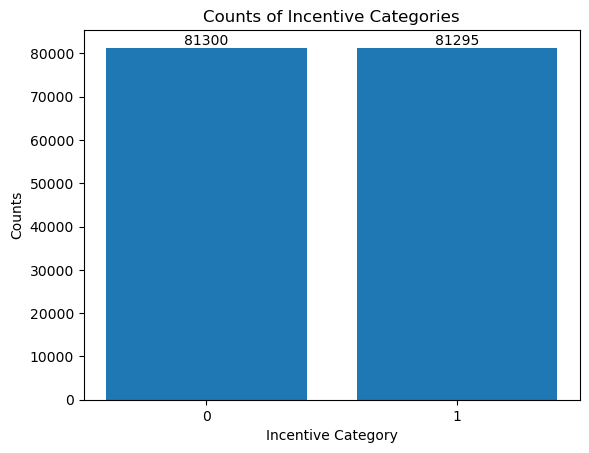

In [16]:
# Plot counts of each category to compare.
plt.bar(counts.index, counts.values)
plt.xlabel("Incentive Category")
plt.ylabel("Counts")
plt.title("Counts of Incentive Categories")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

Text(0.5, 1.0, 'Total NYSERDA Incentive vs. Project Cost')

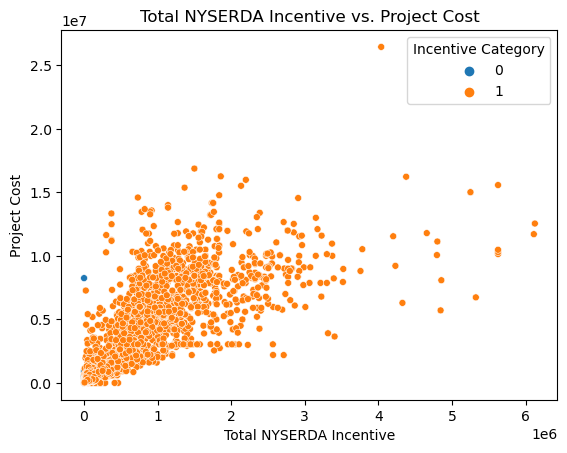

In [17]:
# Plot to compare Total NYSERDA Incentive vs. Project Cost with category coloring to check for relationship.
sns.scatterplot(x=nyserda_df['Total NYSERDA Incentive'], y=nyserda_df['Project Cost'], hue=nyserda_df['Incentive Category'], s=25).set_title("Total NYSERDA Incentive vs. Project Cost")

Text(0.5, 1.0, 'Total NYSERDA Incentive vs. Expected KWh Annual Production')

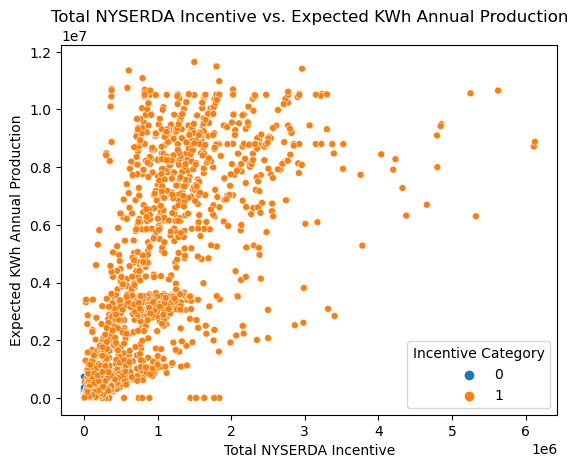

In [18]:
# Plot to compare the Total NYSERDA Incentive vs. Expected KWh Annual Production with category coloring to check for relationship.
sns.scatterplot(x=nyserda_df['Total NYSERDA Incentive'], y=nyserda_df['Expected KWh Annual Production'], hue=nyserda_df['Incentive Category'], s=25).set_title("Total NYSERDA Incentive vs. Expected KWh Annual Production")

## Split Data for Training and Testing

In [19]:
# Define data frame of just columns that the model will use.  Review the data set.
x = nyserda_df[['Project Cost', 'Expected KWh Annual Production']]
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162595 entries, 0 to 162729
Data columns (total 2 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Project Cost                    162595 non-null  float64
 1   Expected KWh Annual Production  162595 non-null  float64
dtypes: float64(2)
memory usage: 3.7 MB


In [20]:
# Define labels from incentive categories as a numpy array.
y = nyserda_df['Incentive Category']
y = np.array(y).astype("float64")

In [21]:
#Split data to training and temporary set.  The split will be 80% for training and 20% for testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)

## Modeling

In [22]:
# Set parameters.
output_dim = 1
loss = 'binary_crossentropy'
optimizer = 'adam'
num_epochs = 50

In [23]:
# Define early stopping criteria.
early_stop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

In [24]:
# Create the model.
model = tf.keras.Sequential()
model.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))

In [25]:
# Compile the model.
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11265 (44.00 KB)
Trainable params: 11265 (44.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Train the model.
model_result = model.fit(x_train, y_train, epochs=num_epochs, validation_split=0.2, callbacks=early_stop)

Epoch 1/50


3252/3252 [==============================] - 4s 882us/step - loss: 12.9943 - accuracy: 0.5433 - val_loss: 0.8213 - val_accuracy: 0.6503
Epoch 2/50
3252/3252 [==============================] - 3s 851us/step - loss: 4.9259 - accuracy: 0.6055 - val_loss: 1.1567 - val_accuracy: 0.7126
Epoch 3/50
3252/3252 [==============================] - 3s 846us/step - loss: 1.3308 - accuracy: 0.6782 - val_loss: 0.5564 - val_accuracy: 0.7258
Epoch 4/50
3252/3252 [==============================] - 3s 878us/step - loss: 1.5749 - accuracy: 0.6276 - val_loss: 0.6923 - val_accuracy: 0.5078
Epoch 5/50
3252/3252 [==============================] - 3s 847us/step - loss: 0.6922 - accuracy: 0.5027 - val_loss: 0.6921 - val_accuracy: 0.5078
Epoch 6/50
3252/3252 [==============================] - 3s 853us/step - loss: 0.6934 - accuracy: 0.4986 - val_loss: 0.6927 - val_accuracy: 0.4939
Epoch 7/50
3252/3252 [==============================] - 3s 853us/step - loss: 0.7225 - accuracy: 0.5003 - val_loss: 0.692

In [27]:
# Review the model using the evaluation results.
eval_results = model.evaluate(x_test, y_test)
print(f'Model loss is {round(eval_results[0], 4)}.')
print(f'Model accuracy is {round(eval_results[1], 4)}.')

1017/1017 [==============================] - 1s 549us/step - loss: 0.5575 - accuracy: 0.7215
Model loss is 0.5575.
Model accuracy is 0.7215.


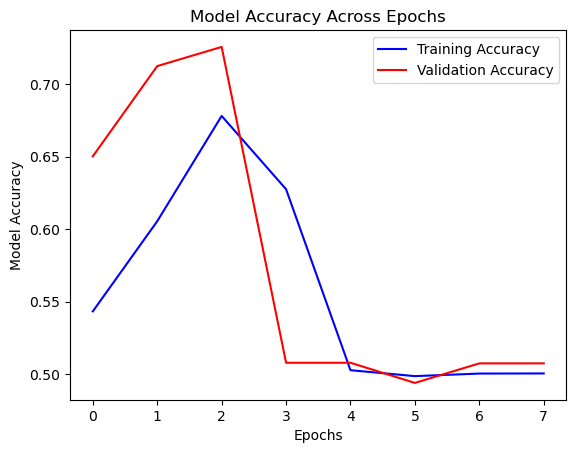

In [28]:
# Review model accuracy from each epoch by plotting the values of the model accuracy.
plt.plot(model_result.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(model_result.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy Across Epochs")
plt.legend()
plt.show()

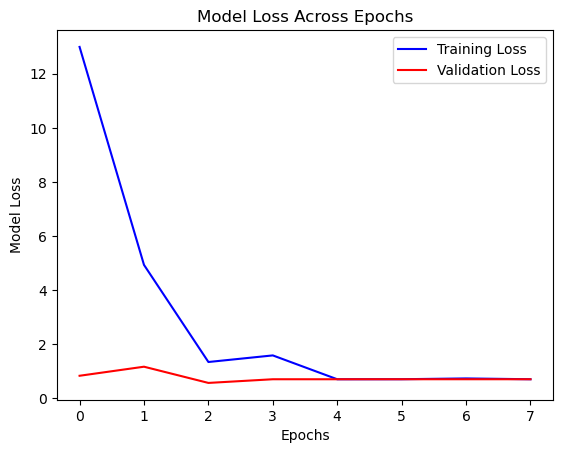

In [29]:
# Review model loss from each epoch by plotting the values of the model accuracy.
plt.plot(model_result.history['loss'], label="Training Loss", color='blue')
plt.plot(model_result.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Model Loss")
plt.title("Model Loss Across Epochs")
plt.legend()
plt.show()

## Make Predictions

In [30]:
# Make predictions based on the model.
predictions = model.predict(x_test)

1017/1017 [==============================] - 1s 504us/step


In [31]:
# Define the predictions and review.
predicted_values = np.round(predictions).flatten().astype(int)
print(predicted_values)

[0 1 0 ... 0 0 0]


In [32]:
# Review model accuracy based on the predictions with a confusion matrix.
conf_matrix = confusion_matrix(y_test, predicted_values)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[11427  4576]
 [ 4481 12035]]


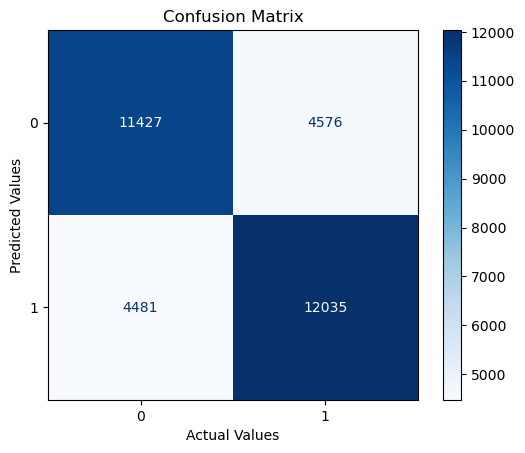

In [33]:
# Visualize the confusion matrix.
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['0','1'])
disp.plot(cmap='Blues')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Confusion Matrix")
plt.show()

## Model Evaluation

In [34]:
# Predict probabilities.
pred_prob = (model.predict(x_test) > 0.5).astype("int32")

1017/1017 [==============================] - 1s 497us/step


In [35]:
# Create the ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, pred_prob, pos_label=1)

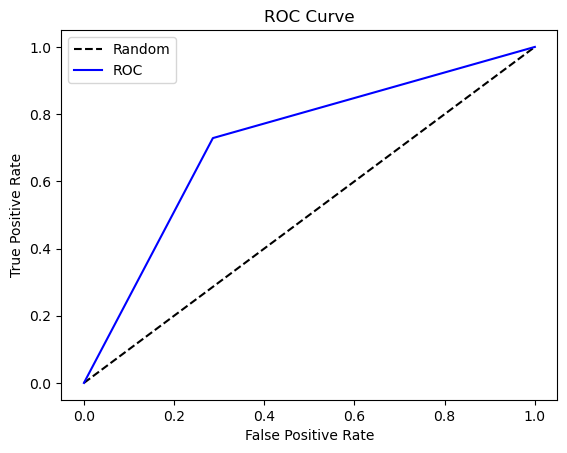

In [36]:
# Plot the ROC curve.
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.plot(fpr, tpr, color='blue', label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [37]:
# Calculate AUC value and print.
roc_auc = round(auc(fpr, tpr), 4)
print("AUC of the model is:", roc_auc)

AUC of the model is: 0.7214
